#  1. Combining Spatial Enhancement Methods



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load Image

In [3]:
def load_image(path):
    return cv2.imread(path, 0).astype(np.float32)

bone_scan_a = load_image('xray1.png')
plt.imshow(bone_scan_a, cmap='gray')

[ WARN:0@1.380] global loadsave.cpp:241 findDecoder imread_('xray1.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'astype'

### Lọc laplacian

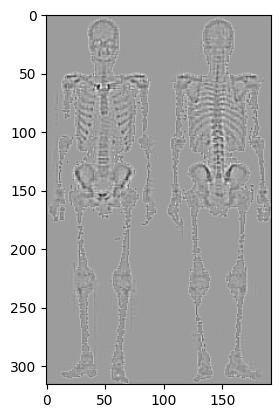

In [5]:
def apply_laplacian(image):
    '''
    Áp dụng phép biến đổi Laplacian lên ảnh để phát hiện các cạnh.

    Hàm này áp dụng bộ lọc Laplacian để tính gradient (độ biến thiên) của ảnh
    nhằm phát hiện các cạnh của đối tượng. Sau đó, ảnh kết quả được chuẩn hóa
    giá trị về khoảng [0, 1] để dễ dàng hiển thị hoặc xử lý.

    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh đầu vào, có thể là ảnh xám hoặc ảnh màu.

    Returns:
    --------
    laplacian_norm : numpy.ndarray
        Ảnh đã được áp dụng phép Laplacian và chuẩn hóa giá trị về khoảng [0, 1].
    '''
    laplacian = cv2.Laplacian(image, cv2.CV_32F, ksize=3)
    return cv2.normalize(laplacian, None, 0, 1, cv2.NORM_MINMAX)

bone_scan_b = apply_laplacian(bone_scan_a)
plt.imshow(bone_scan_b, cmap='gray')

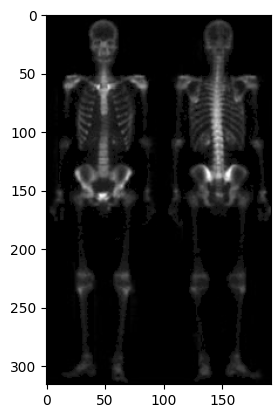

In [6]:
def sharpen_subtract(image1, image2):
    '''
    Tạo hiệu ứng làm sắc nét hình ảnh bằng cách trừ hai ảnh.

    Hàm này thực hiện phép trừ điểm ảnh giữa hai ảnh đầu vào để tạo ra một ảnh sắc nét hơn.
    Parameters:
    -----------
    image1 : numpy.ndarray
    image2 : numpy.ndarray

    Returns:
    --------
    sharpened_image : numpy.ndarray
        Ảnh đã được làm sắc nét sau khi thực hiện phép trừ giữa hai ảnh.
    '''
    return cv2.subtract(image1, image2)

bone_scan_c = sharpen_subtract(bone_scan_a, bone_scan_b)
plt.imshow(bone_scan_c, cmap='gray')

### Lọc sobel

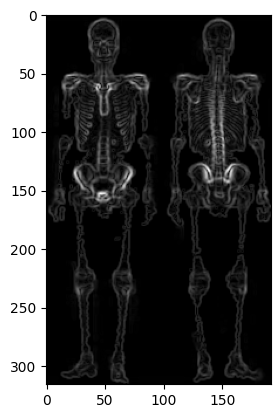

In [7]:
def apply_sobel(image):
    '''
    Áp dụng bộ lọc Sobel để tính gradient của ảnh theo hướng x và y,
    sau đó trả về độ lớn của gradient để phát hiện các cạnh trong ảnh.

    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh đầu vào.

    Returns:
    --------
    magnitude : numpy.ndarray
        Ảnh chứa độ lớn của gradient, thể hiện cường độ của các cạnh.
    '''
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    return cv2.magnitude(gx, gy)

bone_scan_d = apply_sobel(bone_scan_c)
plt.imshow(bone_scan_d, cmap='gray')

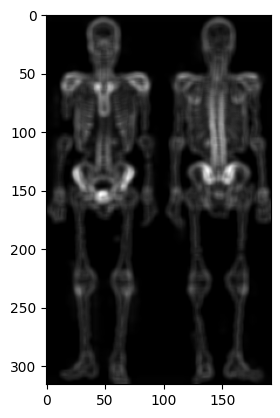

In [8]:
def apply_blur(image):
    return cv2.blur(image, (5, 5)).astype(np.float32)

bone_scan_e = apply_blur(bone_scan_d)
plt.imshow(bone_scan_e, cmap='gray')


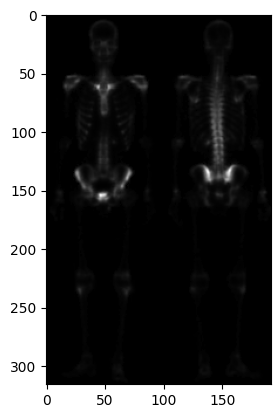

In [9]:
def apply_multiply(image1, image2):
    return cv2.multiply(image1, image2)

bone_scan_f = apply_multiply(bone_scan_c, bone_scan_e)
plt.imshow(bone_scan_f, cmap='gray')

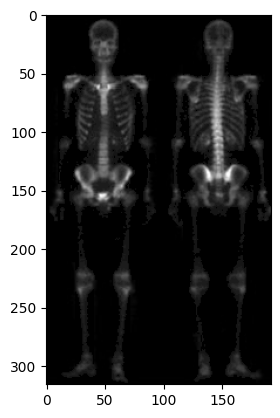

In [10]:
def apply_add(image1, image2):
    return cv2.addWeighted(image1, 1, image2, 0, 0)

bone_scan_g = apply_add(bone_scan_a, bone_scan_f)
plt.imshow(bone_scan_g, cmap='gray')

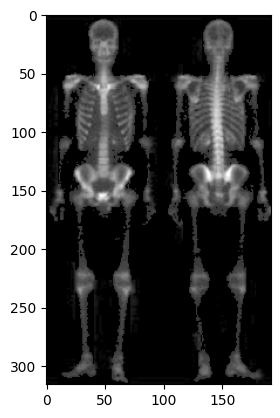

In [11]:
def apply_power_law_transform(image, gamma):
    return (np.power(image.astype(np.float64) / 255.0, gamma) * 255).astype(np.uint64)

bone_scan_h = apply_power_law_transform(bone_scan_g, 0.6)
plt.imshow(bone_scan_h, cmap='gray')

# 2. Find Contours Function


**B1 : Chuyển ảnh nhị phân cắt ngưỡng => trả về 2 giá trị nền màu đen =0 và đối tượng giá trị = 1(255)**


**B2 : Xác định được tập hợp các đường biên mô tả cho đối tượng đó**

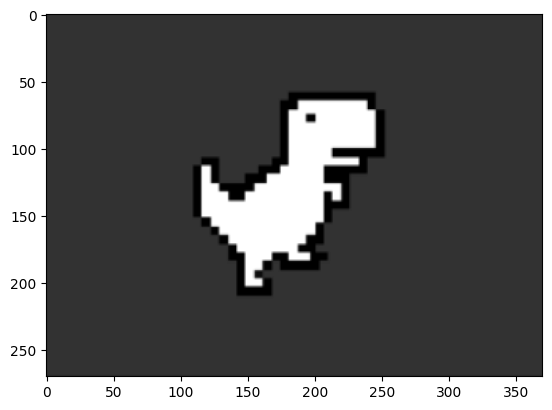

In [17]:
img_pino = cv2.imread('pino2.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_pino, cmap='gray')
plt.show()

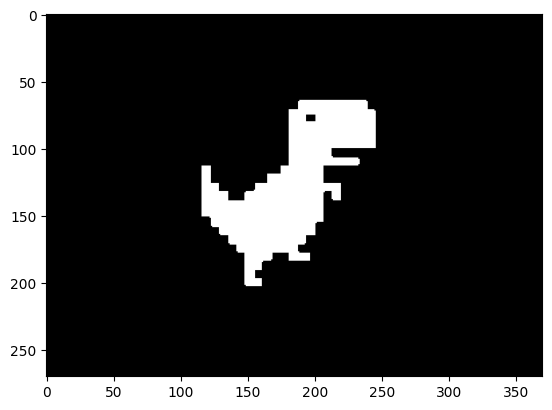

In [18]:
# apply some threshold to getting pure 0 or 255 values.
_ , threshold_img = cv2.threshold(img_pino, 127, 255, cv2.THRESH_BINARY)
plt.imshow(threshold_img, cmap='gray')
plt.show()

In [26]:

def findContours(img, mode='RETR_LIST'):
    '''
    Tìm các đường biên (contours) của đối tượng trong ảnh đầu vào.

    Hàm này áp dụng ngưỡng (threshold) lên ảnh để chuyển đổi sang ảnh nhị phân
    (các giá trị 0 và 255) và xác định các đường biên của đối tượng theo hai chiều:
    ngang và dọc. Tùy vào chế độ `mode`, hàm sẽ trả về tất cả các đường biên hoặc
    chỉ đường biên ngoài của đối tượng.

    Parameters:
    -----------
    img : numpy.ndarray
        Ảnh đầu vào, là ảnh xám (grayscale) chứa các giá trị pixel trong khoảng 0-255.

    mode : str, optional
        Chế độ tìm contours, có hai lựa chọn:
        - 'RETR_LIST': Tìm tất cả các đường biên của đối tượng, không phân biệt trong hay ngoài.
        - 'RETR_EXTERNAL': Chỉ tìm đường biên ngoài cùng của đối tượng.

    Returns:
    --------
    h_landmarks : list
        Danh sách các tọa độ điểm biên của đối tượng theo chiều ngang,
        lưu trữ dưới dạng cặp giá trị [y, x].

    v_landmarks : list
        Danh sách các tọa độ điểm biên của đối tượng theo chiều dọc,
        lưu trữ dưới dạng cặp giá trị [y, x].
    '''
    # adding threshold for pure 0 or 255 values image.
    _ , threshold_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    rows, cols = img.shape

    if mode=='RETR_LIST':
        # Horizontally
        h_landmarks = []
        for i in range(rows):
            object_in_row = False
            for j in range(cols):
                if threshold_img[i, j]==255 and object_in_row==False:
                    object_in_row = True
                    h_landmarks.append([i, j]) # append in [y, x] format
                elif threshold_img[i, j]==0 and object_in_row==True:
                    object_in_row = False
                    h_landmarks.append([i, j])

        # Vertically
        v_landmarks = []
        for i in range(cols):
            object_in_col = False
            for j in range(rows):
                if threshold_img[j, i]==255 and object_in_col==False:
                    object_in_col = True
                    v_landmarks.append([j, i]) # append in [y, x] format
                elif threshold_img[j, i]==0 and object_in_col==True:
                    object_in_col = False
                    v_landmarks.append([j, i])


    elif mode=='RETR_EXTERNAL':
        # Horizontally
        h_landmarks = []
        for i in range(rows):
            object_in_row = False
            exist = False
            tmp = []
            for j in range(cols):
                if threshold_img[i, j]==255 and object_in_row==False:
                    object_in_row = True
                    exist = True
                    tmp.append([i, j]) # append in [y, x] format
                elif threshold_img[i, j]==0 and object_in_row==True:
                    object_in_row = False
                    tmp.append([i, j])
            if exist:
                h_landmarks.extend([tmp[0], tmp[-1]])


        # Vertically
        v_landmarks = []
        for i in range(cols):
            object_in_col = False
            exist = False
            tmp = []
            for j in range(rows):
                if threshold_img[j, i]==255 and object_in_col==False:
                    object_in_col = True
                    exist = True
                    tmp.append([j, i]) # append in [y, x] format
                elif threshold_img[j, i]==0 and object_in_col==True:
                    object_in_col = False
                    tmp.append([j, i])
            if exist:
                v_landmarks.extend([tmp[0], tmp[-1]])


    return h_landmarks, v_landmarks

In [21]:
h_lands, v_lands = findContours(img_pino, 'RETR_EXTERNAL')


In [22]:
bgr_img = cv2.cvtColor(threshold_img, cv2.COLOR_GRAY2BGR)
res_img = bgr_img.copy()

In [23]:
for vl in v_lands:
    cv2.circle(res_img, (vl[1], vl[0]), 1, (0,127,0), -1)
for hl in h_lands:
    cv2.circle(res_img, (hl[1], hl[0]), 1, (0,127,0), -1)

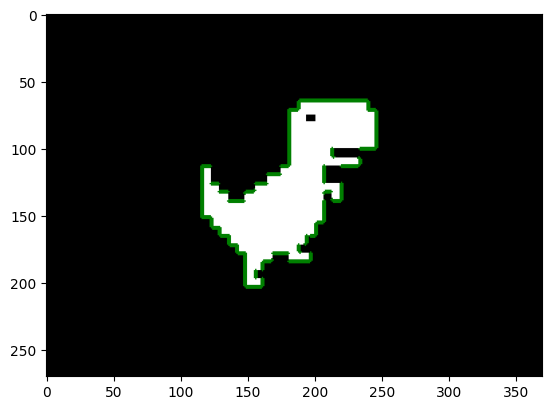

In [24]:
plt.imshow(res_img)
plt.show()

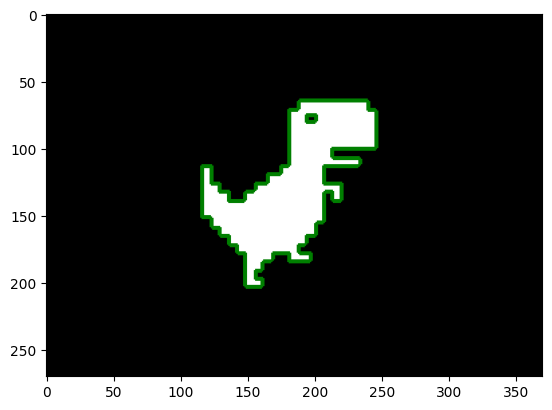

In [28]:
# RETR_LIST mode:
h_lands, v_lands = findContours(img_pino, 'RETR_LIST')

bgr_img = cv2.cvtColor(threshold_img, cv2.COLOR_GRAY2BGR)
res_img = bgr_img.copy()

for vl in v_lands:
    cv2.circle(res_img, (vl[1], vl[0]), 1, (0,127,0), -1)
for hl in h_lands:
    cv2.circle(res_img, (hl[1], hl[0]), 1, (0,127,0), -1)

plt.imshow(res_img)
plt.show()

# 3. Dice Recognition


**Mục tiêu : Phát biệt đường biên ngoài và trong của con  xúc sắc**

[[355.85     278.85      15.67    ]
 [275.55002  198.55      15.889999]]


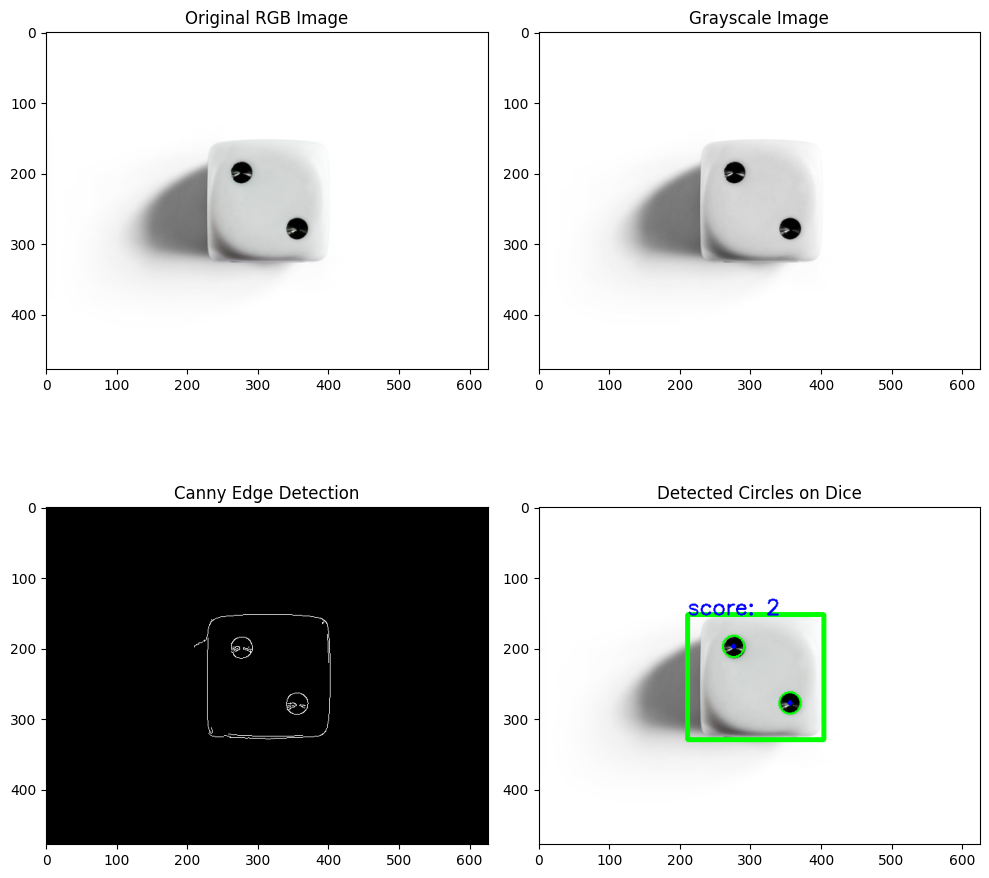

In [6]:
def Dice_Recognition(path_img):
    plt.figure(figsize=(10,10))
    # Load image rgb and gray
    img = cv2.imread(path_img)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply canny edge detection
    thresh = cv2.threshold(gray_img,220,255, cv2.THRESH_BINARY_INV)[1]

    detected_edges = cv2.Canny(gray_img,9, 150, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    close = cv2.morphologyEx(detected_edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    circles = cv2.HoughCircles(close,cv2.HOUGH_GRADIENT,1.1,20,param1=50,param2=30,minRadius=5,maxRadius=55)
    circles=circles[0,:]
    print(circles)
    # Subplot 1: Original RGB image
    plt.subplot(2, 2, 1)
    plt.imshow(rgb_img)
    plt.title("Original RGB Image")
    
    # Subplot 2: Grayscale image
    plt.subplot(2, 2, 2)
    plt.imshow(gray_img, cmap='gray')
    plt.title("Grayscale Image")
    
    # Subplot 3: Detected Edges
    plt.subplot(2, 2, 3)
    plt.imshow(detected_edges, cmap='gray')
    plt.title("Canny Edge Detection")
    # Draw circles
    for i in circles:
        # draw the outer circle
        cv2.circle(rgb_img,(int(i[0]),int(i[1])),int(i[2]),(0,255,0),2)
        # draw the center of the circle
        cv2.circle(rgb_img,(int(i[0]),int(i[1])),2,(0,0,255),3)
    
    contours, hierarchy = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x0, y0, w0, h0= cv2.boundingRect(contours[0])
    cv2.rectangle(rgb_img, (x0,y0),(x0+w0,y0+h0), (0,255,0),5)

    dice0 = close[y0:y0+h0, x0:x0+w0]
    circles0 = cv2.HoughCircles(dice0,cv2.HOUGH_GRADIENT,1.3,20,param1=50,param2=30,minRadius=5,maxRadius=55)
    cv2.putText(rgb_img, f'score: {len(circles0[0])}', (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    # Subplot 4: Image with circles
    plt.subplot(2, 2, 4)
    plt.imshow(rgb_img)
    plt.title("Detected Circles on Dice")
    
    plt.tight_layout()
    plt.show()

Dice_Recognition('img/0.jpg')